In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.3.0


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.1 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you'll have scipy 1.5.2 which is incompatible.
You should consider upgrading via the '/Users/snehgurdasani/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile

In [7]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [8]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 127s 0us/step


In [9]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type='GZIP')

In [10]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


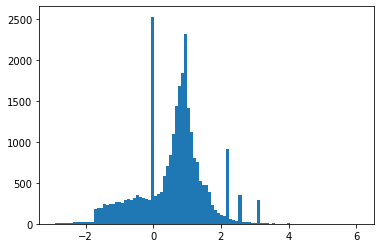

In [12]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [17]:
# Training procedure
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
0.001,
decay_steps = STEPS_PER_EPOCH*1000,
decay_rate = 1,
staircase = False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

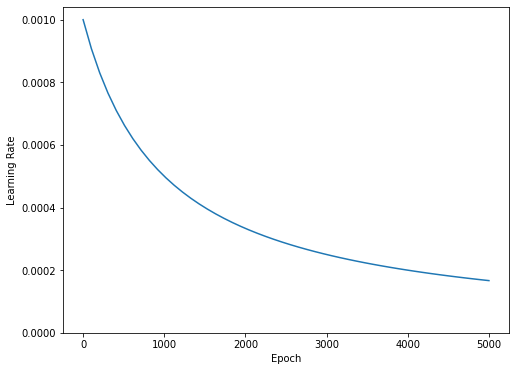

In [19]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [20]:
def get_callbacks(name):
    return [tfdocs.modeling.EpochDots(),
           tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',patience=200),
           tf.keras.callbacks.TensorBoard(logdir/name),
           ]

In [21]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),'accuracy'])
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose=0
    )
    return history

In [25]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [26]:
size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4813,  binary_crossentropy:1.0266,  loss:1.0266,  val_accuracy:0.4910,  val_binary_crossentropy:0.8470,  val_loss:0.8470,  
....................................................................................................
Epoch: 100, accuracy:0.5948,  binary_crossentropy:0.6286,  loss:0.6286,  val_accuracy:0.5700,  val_binary_crossentropy:0.6283,  val_loss:0.6283,  
....................................................................................................
Epoch: 200, accuracy:0.

(0.5, 0.7)

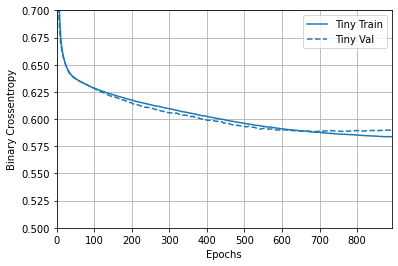

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [28]:
# Small Model
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [29]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4738,  binary_crossentropy:0.7412,  loss:0.7412,  val_accuracy:0.4580,  val_binary_crossentropy:0.7183,  val_loss:0.7183,  
....................................................................................................
Epoch: 100, accuracy:0.6108,  binary_crossentropy:0.6203,  loss:0.6203,  val_accuracy:0.6140,  val_binary_crossentropy:0.6151,  val_loss:0.

In [30]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4785,  binary_crossentropy:0.6972,  loss:0.6972,  val_accuracy:0.4870,  val_binary_crossentropy:0.6775,  val_loss:0.6775,  
....................................................................................................
E

In [33]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [34]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5077,  binary_crossentropy:0.8321,  loss:0.8321,  val_accuracy:0.4630,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

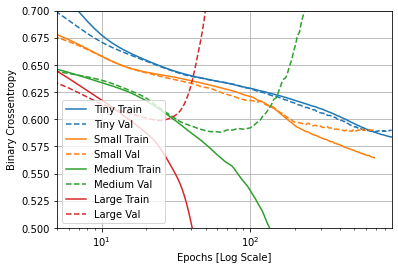

In [35]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [36]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

In [37]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

In [38]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/nj/f9l6vhs50h975cdq0gphfn500000gn/T/tmp5k_g_dqm/tensorboard_logs/regularizers/Tiny')

In [39]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [40]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation = 'elu',
                kernel_regularizer = regularizers.l2(0.001),
                input_shape=(FEATURES,)),
    layers.Dense(512, activation = 'elu',
                kernel_regularizer= regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                kernel_regularizer= regularizers.l2(0.001)),
    layers.Dense(512, activation = 'elu',
                kernel_regularizer= regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4959,  binary_crossentropy:0.8325,  loss:2.3528,  val_accuracy:0.5600,  val_binary_crossentr

(0.5, 0.7)

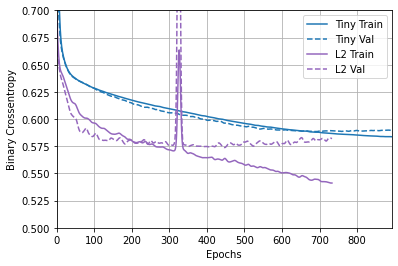

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5,0.7])

In [42]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

In [43]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined']  = compile_and_fit(combined_model,"regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)              

(0.5, 0.7)

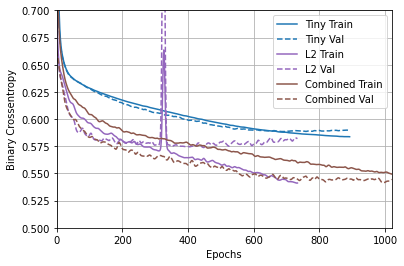

In [44]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])